In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import os
import pathlib

In [3]:
data_path = pathlib.Path("libras")
data_path = os.path.join(data_path, os.listdir(data_path)[1])
print(data_path)

libras\train


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    image_size = (64, 64),
    batch_size = 32
)

Found 34714 files belonging to 21 classes.
Using 27772 files for training.


In [5]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    image_size = (64, 64),
    batch_size = 32
)

Found 34714 files belonging to 21 classes.
Using 6942 files for validation.


In [6]:
class_names = dataset.class_names

In [7]:
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'I',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y']

H, J, K, X e Z não compõem o dataset pois são sinais feitos com movimentos

In [8]:
dataset.element_spec

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

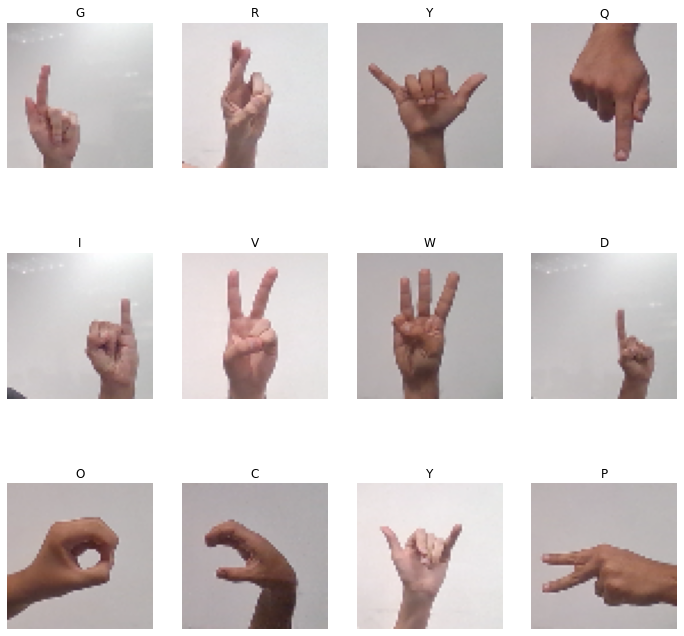

In [9]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Pré-processamento + mapped_function

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = dataset.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(64, 64),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
# vgg16 = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet")

# vgg16.trainable = False

# inputs = tf.keras.Input(shape=(64, 64, 3))
# x = tf.keras.applications.vgg16.preprocess_input(
#     inputs, data_format=None)

# x = vgg16(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(4096, activation="relu")(x)
# x = tf.keras.layers.Dense(4096, activation="relu")(x)
# outputs = tf.keras.layers.Dense(21, activation="softmax")(x)
# model = tf.keras.Model(inputs, outputs)

In [13]:
#modelling

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(21,activation='softmax')
])

Adicionar Dropout
tf.keras.layers.Dropout(0.2)(x)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)       

In [15]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [16]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [18]:
# tf.config.experimental.list_physical_devices('GPU')

In [18]:
# early stopping default do tensorflow
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

### Com 30 epochs

In [19]:
history = model.fit(train_ds, epochs=30, validation_data=test, callbacks=[callback])


Epoch 1/30
868/868 [==============================] - 67s 77ms/step - loss: 2.1849 - accuracy: 0.3257 - val_loss: 1.0731 - val_accuracy: 0.6698
Epoch 2/30
868/868 [==============================] - 67s 77ms/step - loss: 0.8002 - accuracy: 0.7514 - val_loss: 0.7151 - val_accuracy: 0.7669
Epoch 3/30
868/868 [==============================] - 68s 78ms/step - loss: 0.4517 - accuracy: 0.8591 - val_loss: 0.5116 - val_accuracy: 0.8361
Epoch 4/30
868/868 [==============================] - 68s 79ms/step - loss: 0.3235 - accuracy: 0.8933 - val_loss: 0.3252 - val_accuracy: 0.8933
Epoch 5/30
868/868 [==============================] - 72s 82ms/step - loss: 0.2598 - accuracy: 0.9128 - val_loss: 0.2905 - val_accuracy: 0.9022
Epoch 6/30
868/868 [==============================] - 72s 83ms/step - loss: 0.2037 - accuracy: 0.9323 - val_loss: 0.1861 - val_accuracy: 0.9391
Epoch 7/30
868/868 [==============================] - 288s 333ms/step - loss: 0.1751 - accuracy: 0.9422 - val_loss: 0.2335 - val_accurac

In [20]:
model.evaluate(test)

217/217 [==============================] - 5s 23ms/step - loss: 0.2174 - accuracy: 0.9293


[0.21736972033977509, 0.9292711019515991]

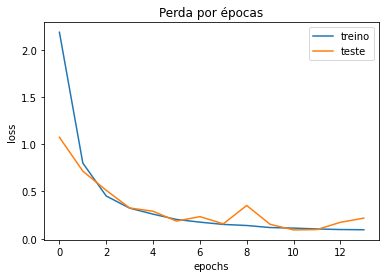

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['treino', 'teste'])

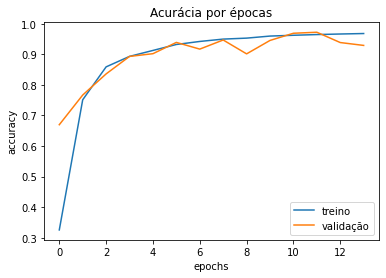

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['treino', 'validação'])

In [23]:
model.save('model_libras.h5')